Working notebook for masther thesis

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.io import loadmat
from scipy import stats
import statsmodels.api as sm
plt.style.use("ggplot")  
%matplotlib inline

from scipy.optimize import least_squares

from scipy.special import erf

from concurrent.futures import ProcessPoolExecutor
from typing import Iterable, Tuple, Dict, Optional

from scipy.stats import linregress

from tqdm import tqdm 

Dataset preparation

In [4]:
mat =loadmat("/Users/davidsandovalrodriguez/Projects/Fund-Kink-Smoothing/data/TFMdata/AllB_JF.mat")

In [5]:
Y     = np.asarray(mat["Y"])       # 540 x 2321
TNA   = np.asarray(mat["TNA"])     # same shape
F     = np.asarray(mat["F"])       # 540 x 5
rf    = np.asarray(mat["rf"]).flatten()  # 540 x 1 → flatten to 1D
style = np.asarray(mat["stylemat"])      # 2321 x 18
fundids = mat["fundids"].flatten()       # 2321 × 1 → fund ID for each column

T, N = Y.shape

# Time and Fund grids
time_idx = np.arange(T)
fund_idx = np.arange(N)

time_grid, fund_grid = np.meshgrid(time_idx, fund_idx, indexing='ij')
df = pd.DataFrame({
    "time": time_grid.ravel(),
    "fund_index": fund_grid.ravel(),
    "fund_id": fundids[fund_grid.ravel()],
    "Y": Y.ravel(),
    "TNA": TNA.ravel(),
    # add more fields if needed (e.g., TNA1, etc.)
})

style_df = pd.DataFrame(style, columns=[f"style_{i+1}" for i in range(style.shape[1])])
style_df["fund_id"] = fundids
df = df.merge(style_df, on="fund_id", how="left")
df.replace(-999, np.nan, inplace=True)
df.shape

F_df = pd.DataFrame(F, columns=[f"F{i+1}" for i in range(F.shape[1])])
F_df["time"] = np.arange(F.shape[0])

# Merge into df
df = df.merge(F_df, on="time", how="left")

df = df.dropna(subset=["Y", "TNA"])
df.shape
df.head()

,time,fund_index,fund_id,Y,TNA,style_1,style_2,style_3,style_4,style_5,...,style_14,style_15,style_16,style_17,style_18,F1,F2,F3,F4,F5
5,0,5,100010,0.005069,64.361911,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
9,0,9,100019,0.158994,35.243098,0,0,0,1,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
15,0,15,100046,0.091393,57.922143,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
16,0,16,100047,0.135792,58.868593,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386
18,0,18,100055,0.141008,3610.879183,0,0,0,0,0,...,0,0,0,0,0,1.0,0.11781,0.128,0.0822,-0.1386


In [15]:
df = df.sort_values(["fund_id","time"])  

Linear model

In [24]:
def estimate_one_fund_lin(fund_df):
    """Returns dict with a, b, beta1...betak, R2, SSE, n_obs for a single fund"""

    y = fund_df["Y"].to_numpy(float)

    X = fund_df[["TNA", "F2", "F3", "F4", "F5"]].copy()
    X.insert(0, "const", 1.0)
    X["TNA"] = -X["TNA"]

    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X, y = X[mask].to_numpy(), y[mask]

    res = sm.OLS(y, X).fit()

    a_hat = res.params[0]
    b_hat = -res.params[1]
    betas = res.params[2:]

    K_theory = a_hat / (2 * b_hat)

    out = {
        "a_lin":a_hat,
        "b_lin":b_hat,
        **{f"beta{j+1}": betas[j] for j in range(len(betas))},
        "R2": res.rsquared,
        "SSE": res.ssr,
        "n_obs": len(y),
        "K_the_lin": K_theory
    }

    return out



def estimate_all_funds_linear(df):
    """
    OLS of every fund in the dataset df
    """

    results = []

    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund_lin(g)
        if est is not None:
            est["fund_id"]=fid
            results.append(est)

    return pd.DataFrame(results)





In [33]:
estimates_lin = estimate_all_funds_linear(df)

100%|██████████| 2321/2321 [00:00<00:00, 2604.01it/s]


In [26]:
estimates_lin

,a_lin,b_lin,beta1,beta2,beta3,beta4,R2,SSE,n_obs,K_the_lin,fund_id
0,0.001492,2.660309e-07,0.962015,-0.018759,0.051107,0.028328,0.944872,0.036179,386,2804.264635,100001
1,0.004300,-1.583310e-06,1.009327,0.619777,-0.017121,0.039970,0.866277,0.109129,316,-1357.875384,100003
2,0.004346,-1.460467e-06,1.009456,0.147759,-0.277096,0.028058,0.922869,0.074584,419,-1487.950849,100004
3,0.006741,-5.913177e-07,0.843809,0.142745,0.331572,0.036263,0.907920,0.022755,184,-5700.289753,100006
4,0.007891,-1.787235e-05,1.085414,0.732124,-0.504707,0.145129,0.820675,0.224937,277,-220.759662,100009
...,...,...,...,...,...,...,...,...,...,...,...
2316,0.007462,-8.449768e-05,0.810392,1.071016,-0.041594,0.017310,0.933816,0.007655,62,-44.154539,603104
2317,0.002532,8.807708e-07,0.899121,0.269719,0.204654,-0.030219,0.888521,0.008236,60,1437.521256,603146
2318,-0.002967,4.924477e-05,1.082990,0.159256,0.228119,-0.043161,0.931297,0.006549,60,-30.123806,603166
2319,0.002993,-1.561511e-05,0.782134,-0.087441,0.321272,0.082336,0.872283,0.005384,63,-95.829927,604486


Smoothed model

In [ ]:
def S_h_gauss(q, K, h):
    """
    Gaussian CDF smooth step  ≈ 1{q <= K}.
    Vectorised for NumPy arrays.
    """
    z = (K - q) / (np.sqrt(2.0) * h)
    return 0.5 * (1.0 + erf(z))

def alpha_smooth_gauss(a, b, K, q, h):
    S  = S_h_gauss(q, K, h)
    return (a - b*q) * S + (a*K - b*K**2) / q * (1.0 - S)

def residuals(theta, q, y, F, h):
    a, b, K   = theta[:3]
    betas     = theta[3:]
    alpha_hat = alpha_smooth_gauss(a, b, K, q, h)  
    y_hat     = alpha_hat + F.dot(betas)
    return y_hat - y


estimating wrappers

In [34]:
def estimate_one_fund(fund_df, h=0.01):
    """Return dict with a,b,K,beta1..betaK,SSE,n_obs for a single fund."""
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            #lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    mask = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[mask], y[mask], F[mask]
    if len(q) < 24:  
        print(q)             # skip tiny time-series
        return None

    # ----- initial guesses -----
    a0, b0, K0 = np.mean(y), 0.0, np.median(q)
    beta0      = np.linalg.lstsq(F, y, rcond=None)[0]
    x0         = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    res = least_squares(residuals, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    ss_tot = np.sum((y - y.mean())**2)
    R2 = 1 - res.cost / ss_tot

    return {
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q),
        "R2"     : R2
    }

# =============================================================
#   Dataset-wide wrapper
# =============================================================
def estimate_all_funds(df, h=0.01):
    """
    Run Gaussian-smooth NLLS for every fund in df.
    Returns a DataFrame of estimates.
    """
    results = []

    # -------- serial with progress bar --------
    for fid, g in tqdm(df.groupby("fund_id")):
        est = estimate_one_fund(g, h)
        if est is not None:
            est["fund_id"] = fid
            results.append(est)

    return pd.DataFrame(results)

estimating wrappers with different initial guess

In [28]:
def estimate_one_fund_guess(fund_df, h=0.01, lin_map=None):
    """
    Non-linear estimator seeded with (a,b) from prior linear fit.
    """
    fund_df = fund_df.sort_values("time")
    q = fund_df["TNA"].to_numpy(float)            # lagged size
    y = fund_df["Y"].to_numpy(float)
    F = fund_df[["F2","F3","F4","F5"]].to_numpy(float)

    msk = (~np.isnan(q)) & (~np.isnan(y)) & (~np.isnan(F).any(axis=1)) & (q > 0)
    q, y, F = q[msk], y[msk], F[msk]
    if len(q) < 24:
        print(q)
        return None                                # skip tiny time series

    # ---------- initial guesses ---------------------------------------
    fid = fund_df["fund_id"].iloc[0]
    if lin_map is not None and fid in lin_map:
        a0 = lin_map[fid]["a"]
        b0 = lin_map[fid]["b"]
    else:                                          # fallback
        a0 = np.mean(y)
        b0 = 0.0

    K0    = np.median(q)                           # still data-driven
    beta0 = np.linalg.lstsq(F, y, rcond=None)[0]

    x0 = np.concatenate(([a0, b0, K0], beta0))

    lb = np.concatenate(([-np.inf, -np.inf, 1e-6], [-np.inf]*len(beta0)))
    ub = np.concatenate(([ np.inf,  np.inf,  np.inf], [ np.inf]*len(beta0)))

    #uncomment to swtich between algorithms

    #res = least_squares(residuals, x0,
    #                    args=(q, y, F, h), method="lm", max_nfev=4000)
    
    res = least_squares(residuals, x0, bounds=(lb, ub),
                        args=(q, y, F, h), method="trf", max_nfev=4000)

    return {
        "fund_id": fid,
        "a"      : res.x[0],
        "b"      : res.x[1],
        "K"      : res.x[2],
        **{f"beta{j+1}": res.x[3+j] for j in range(len(beta0))},
        "SSE"    : res.cost,
        "success": res.success,
        "n_obs"  : len(q)
    }

def estimate_all_funds_guess(df, h=0.01, lin_map=None):
    results = []

    for fid, g in tqdm(df.groupby("fund_id")):
        out = estimate_one_fund_guess(g, h=h, lin_map=lin_map)
        if out is not None:
            results.append(out)

    return pd.DataFrame(results)


In [35]:
estimates = estimate_all_funds(df, h=0.0000001)

100%|██████████| 2321/2321 [00:07<00:00, 317.89it/s]


In [36]:
estimates 

,a,b,K,beta1,beta2,beta3,beta4,SSE,success,n_obs,R2,fund_id
0,0.007624,8.225387e-06,837.309593,0.966152,-0.016394,0.056435,0.031095,0.017620,True,386,0.973152,100001
1,0.003305,2.644972e-08,956.523005,1.009870,0.619490,-0.018585,0.039602,0.054539,True,316,0.933170,100003
2,0.003189,-6.335544e-05,125.260225,1.010595,0.149528,-0.277238,0.028855,0.036414,True,419,0.962342,100004
3,0.006195,1.590428e-07,4310.975355,0.843026,0.144365,0.333556,0.035365,0.011372,True,184,0.953984,100006
4,0.018989,3.105228e-04,46.133355,1.090123,0.738502,-0.504273,0.148665,0.110349,True,277,0.912027,100009
...,...,...,...,...,...,...,...,...,...,...,...,...
2316,0.008326,1.079221e-04,56.859713,0.811253,1.071628,-0.042786,0.016686,0.003821,True,62,0.966968,603104
2317,0.002260,-2.468175e-06,477.463574,0.898437,0.270891,0.205430,-0.030231,0.004111,True,60,0.944359,603146
2318,-0.004533,-1.220818e-04,63.524798,1.081938,0.151262,0.229761,-0.042265,0.003254,True,60,0.965861,603166
2319,0.002711,6.852370e-06,57.091934,0.781907,-0.087417,0.323181,0.082772,0.002689,True,63,0.936216,604486


In [31]:
estimates["K_theory"] = estimates["a"] / (2 * estimates["b"])

Comparing methods

In [38]:
cmp = (estimates_lin[["fund_id", "R2"]].rename(columns={"R2":"R2_lin"})).merge(estimates[["fund_id", "R2"]].rename(columns={"R2":"R2_no"}), on="fund_id", how="inner")

In [40]:
cmp["R2_delta"] = cmp["R2_no"] - cmp["R2_lin"]

In [43]:
cmp[["R2_lin", "R2_no", "R2_delta"]].mean()

R2_lin      0.882220
R2_no       0.941863
R2_delta    0.059643
dtype: float64

funcional 

In [47]:
def plot_func_fund(fundID):
    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    q_grid = np.linspace(0.0001, 10*k_hat, 1000)

    h = 0.0000001

    alpha_grid = alpha_smooth_gauss(a_hat, b_hat, k_hat, q_grid, h)

    plt.figure(figsize=(6,4))
    plt.plot(q_grid,alpha_grid)
    plt.show()



/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_3177/2776538698.py:11: RuntimeWarning: divide by zero encountered in divide
  return (a - b*q) * S + (a*K - b*K**2) / q * (1.0 - S)
/var/folders/f_/lhvlm_j976x1lyjxn3zx6c3m0000gn/T/ipykernel_3177/2776538698.py:11: RuntimeWarning: invalid value encountered in multiply
  return (a - b*q) * S + (a*K - b*K**2) / q * (1.0 - S)


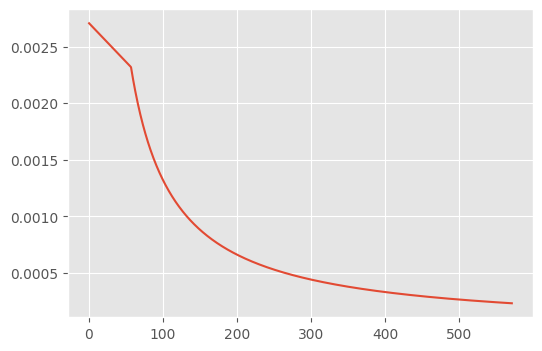

In [45]:
plot_func_fund(604486)

In [ ]:
def plot_func_fund_li_nolin(fundID):
    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    q_grid = np.linspace(0.0001, 2*k_hat, 1000)

    h = 0.0000001

    alpha_grid = alpha_smooth_gauss(a_hat, b_hat, k_hat, q_grid, h)

    plt.figure(figsize=(6,4))
    plt.plot(q_grid,alpha_grid)
    
    a_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "a_lin"].iat[0]
    b_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "b_lin"].iat[0]
    #k_hatl = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]


    alpha_gridl = a_hatl - b_hatl * q_grid

    #plt.figure(figsize=(6,4))
    plt.plot(q_grid,alpha_gridl)

    
    plt.show()

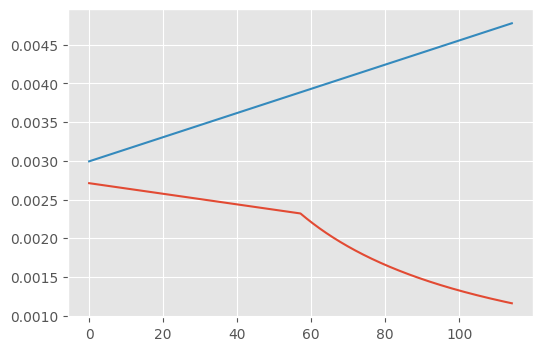

In [98]:
plot_func_fund_li_nolin(604486)

In [90]:
def plot_fit_fund_li_nolin(fundID):

    g = df[df["fund_id"] == fundID].sort_values("time")
    q = g["TNA"].to_numpy(float)
    y = g["Y"].to_numpy(float)
    F = g[["F2", "F3", "F4", "F5"]].to_numpy(float)


    a_hat = estimates.loc[estimates["fund_id"] == fundID, "a"].iat[0]
    b_hat = estimates.loc[estimates["fund_id"] == fundID, "b"].iat[0]
    k_hat = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_col = [c for c in estimates.columns if c.startswith("beta")]
    beta_hat = estimates.loc[estimates["fund_id"] == fundID, beta_col].to_numpy(float).reshape(-1, 1)

    
    
    a_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "a_lin"].iat[0]
    b_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, "b_lin"].iat[0]
    #k_hatl = estimates.loc[estimates["fund_id"] == fundID, "K"].iat[0]

    beta_coll = [c for c in estimates_lin.columns if c.startswith("beta")]
    beta_hatl = estimates_lin.loc[estimates_lin["fund_id"] == fundID, beta_coll].to_numpy(float).reshape(-1, 1)

    h = 0.0000001

    y_hat_nl = alpha_smooth_gauss(a_hat, b_hat, k_hat, q, h) + F.dot(beta_hat).flatten()

    y_hat_lin = (a_hatl - b_hatl * q) + F.dot(beta_hatl).flatten()

    print(y_hat_nl.shape)
    print(y.shape)

    plt.figure(figsize=(6,4))
    plt.scatter(y_hat_nl, y, s=18, alpha= 0.8, marker="x", label= "Non-linear")
    plt.scatter(y_hat_lin, y, s=18, alpha= 0.3, label= "linear")

    plt.xlabel("Predicted Y")
    plt.ylabel("Actual Y")
    plt.title(f"Actual vs. Predicted Values for Fund {fundID}")
    plt.legend();
    
    plt.show()

(63,)
(63,)


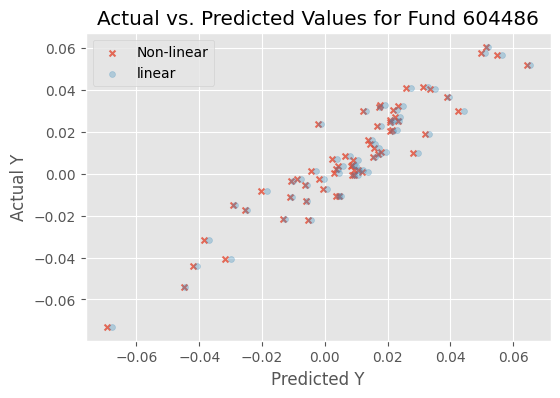

In [94]:
plot_fit_fund_li_nolin(604486)